In [65]:
import pyart
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import arm_sapr_tools
from copy import deepcopy
import pydsd
import pytmatrix
from scipy.special import gamma
from scipy.integrate import trapz
from scipy import constants
%matplotlib inline

In [2]:
houston_radar = pyart.io.read('/data/houston/data/20170101/KHGX_sur_20170101.154633.nc')

In [3]:
z_fld = deepcopy(houston_radar.fields['reflectivity'])
for sweep in houston_radar.sweep_number['data']:
    print(sweep)
    my_x, my_y, my_z = houston_radar.get_gate_x_y_z(sweep)
    my_n = arm_sapr_tools.synthesize.gaussian_iso_storm_with_sclw(my_x, my_y, my_z, 
                        x0=45000., y0=45000.,fzl=4000.0, sclw_depth=4000.,
                       radius=10000.)
    i1 = houston_radar.sweep_start_ray_index['data'][sweep]
    i2 = houston_radar.sweep_end_ray_index['data'][sweep]
    z_fld['data'][i1:i2] = my_n[0:-1]
houston_radar.add_field('number', z_fld, replace_existing=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


16777.015829086115
17758.806713792765
0.5442415546919397 1.159397969683511


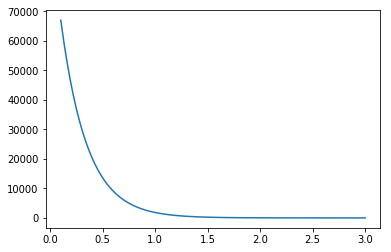

In [79]:
"""
This demo replicates Fig. 7.7 from Bringi and Chandrasekar (2001),
Polarimetric Weather Radar: Principles and Applications. It shows the
specific differential phase (Kdp) normalized by the total water content (W)
as a function of the mass-weighted mean diameter.
"""

#from PyTMatrix https://github.com/jleinonen/pytmatrix/wiki/PyTMatrix-Kdp-example
# define an exponential psd (eq. 7.12 with mu=0)
class ExponentialPSD(object):
    def __init__(self, lam=1.0, N0=1.0):
        self.lam = float(lam)
        self.N0 = float(N0)

    def __call__(self, D):
        return self.N0*np.exp(-self.lam*D)


# the Beard-Chuang axis ratio (eq. 7.3)
def axis_ratio(D):
    return 1.0/(1.0048 + 5.7e-4*D - 2.628e-2*D**2 + 3.682e-3*D**3 -
                1.677e-4*D**4)


Dm = 1.0
lam = 4.0/Dm  # corresponding lambda parameters
W = np.pi*1e3*(Dm/4.0)**4  # corresponding water content

myPSD = ExponentialPSD(lam=lam, N0 = (1e5))
diameters = np.linspace(.1,3,100)

plt.plot(diameters, myPSD(diameters))
print(trapz( myPSD(diameters), dx = (diameters[1] - diameters[0])))
print(myPSD(diameters).sum()*(diameters[1] - diameters[0]))

scatterer = pytmatrix.tmatrix.Scatterer()
scatterer.set_geometry(pytmatrix.tmatrix_aux.geom_horiz_forw)

wavelength = constants.c/10.0e9 * 1e3  # in mm
ref_index = complex(7.718, 2.473)

# set up orientation averaging, Gaussian PDF with mean=0 and std=7 deg
scatterer.or_pdf = pytmatrix.orientation.gaussian_pdf(7.0)  # orientation PDF
scatterer.orient = pytmatrix.orientation.orient_averaged_fixed  # averaging method

# set up PSD integration
scatterer.psd_integrator = pytmatrix.psd.PSDIntegrator()
scatterer.psd_integrator.D_max = 8.0  # maximum diameter considered
scatterer.psd_integrator.geometries = (pytmatrix.tmatrix_aux.geom_horiz_back, pytmatrix.tmatrix_aux.geom_horiz_forw)
scatterer.psd_integrator.axis_ratio_func = axis_ratio
scatterer.psd = myPSD
scatterer.wavelength = wavelength
scatterer.m = ref_index
scatterer.psd_integrator.init_scatter_table(scatterer)
kdp = pytmatrix.radar.Kdp(scatterer)
zdr = pytmatrix.radar.Zdr(scatterer)

print(kdp,zdr)

In [48]:
dsd_gamma = my_psd(diameters)
tots = trapz(dsd_gamma, dx = (diameters[1]- diameters[0]))
print(tots)

90.29669525205968


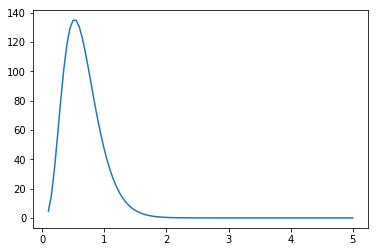

In [38]:
plt.plot(diameters, my_psd(diameters))

In [23]:
pytmatrix.psd.GammaPSD?